In [1]:
import nltk

In [3]:
sentence = 'Hello My name is Saransh. I am a student at SRM University'
tokens = nltk.word_tokenize(sentence)

In [4]:
tokens

['Hello',
 'My',
 'name',
 'is',
 'Saransh',
 '.',
 'I',
 'am',
 'a',
 'student',
 'at',
 'SRM',
 'University']

In [6]:
sentence = nltk.sent_tokenize(sentence)

In [7]:
sentence

['Hello My name is Saransh.', 'I am a student at SRM University']

In [8]:
tagged = nltk.pos_tag(tokens)

In [9]:
tagged

[('Hello', 'NNP'),
 ('My', 'NNP'),
 ('name', 'NN'),
 ('is', 'VBZ'),
 ('Saransh', 'NNP'),
 ('.', '.'),
 ('I', 'PRP'),
 ('am', 'VBP'),
 ('a', 'DT'),
 ('student', 'NN'),
 ('at', 'IN'),
 ('SRM', 'NNP'),
 ('University', 'NNP')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)

In [16]:
print(entities[0])

(PERSON Hello/NNP)


In [19]:
from nltk.corpus import treebank
t = treebank.parsed_sents('wsj_0001.mrg')[0]
t.draw()

In [88]:
import pandas as pd 
data = pd.read_csv('D:\Data_Sets\IMDB Dataset.csv')
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re
import pandas as pd

#TQDM is a progress bar library with good support for nested loops and Jupyter/IPython notebooks.
from tqdm import tqdm


In [5]:
from keras.utils import to_categorical
import random
# from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

#set random seed for the session and also for tensorflow that runs in background for keras
# set_random_seed(123)
# random.seed(123)

In [6]:
train= pd.read_csv("D:\Data_Sets\Movie Reviews\TRAIN.tsv", sep="\t")
test = pd.read_csv("D:\Data_Sets\Movie Reviews\TEST.tsv", sep="\t")

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)



In [8]:
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

  0%|                                                                           | 1/156060 [00:03<157:17:48,  3.63s/it]E:\Anaconda\envs\Tensorflow\lib\site-packages\bs4\__init__.py:312: UserWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
  0%|▏                                                                         | 300/156060 [00:03<53:52:39,  1.25s/it]E:\Anaconda\envs\Tensorflow\lib\site-packages\bs4\__init__.py:312: UserWarning: "source" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % self._decode_markup(markup)
  1%|▍                                                                          | 827/156060 [00:04<9:03:31,  4.76it/s]E:\Anaconda\envs\Tensorflow\lib\site-packages\bs4\__init__.py:312: UserWarning: "..." looks like a filename, not markup. You should probab

156060
66292


In [9]:
target=train.Sentiment.values
y_target=to_categorical(target)
num_classes=y_target.shape[1]


In [10]:
X_train,X_val,y_train,y_val=train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [11]:
#It is needed for initializing tokenizer of keras and subsequent padding

unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████████████████████████████████████████████████████████████████| 124848/124848 [00:00<00:00, 342506.38it/s]

13739
48


In [12]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [13]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]


In [14]:
#Model using Keras LSTM

#Multilayer Perceptron (MLP) for multi-class softmax classification:
#Let’s build what’s probably the most popular type of model in NLP at the moment: Long Short Term Memory network. 
#This architecture is specially designed to work on sequence data.
#It fits perfectly for many NLP tasks like tagging and text classification.
#It treats the text as a sequence rather than a bag of words or as ngrams.

#Here’s a possible model definition:

model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4121700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 4,397,761
Trainable params: 4,397,761
Non-trainable params: 0
____________________________________________

In [15]:
#This is done for learning purpose only. One can play around with different hyper parameters combinations
#and try increase the accuracy even more. For example, a different learning rate, an extra dense layer 
# before output layer, etc. Cross validation could be used to evaluate the model and grid search 
# further to find unique combination of parameters that give maximum accuracy. This model has a validation
#accuracy of around 66.5%
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

E:\Anaconda\envs\Tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 413s 3ms/step - loss: 1.0113 - accuracy: 0.5947 - val_loss: 0.8593 - val_accuracy: 0.6489
Epoch 2/6


E:\Anaconda\envs\Tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


124848/124848 [==============================] - 193s 2ms/step - loss: 0.8169 - accuracy: 0.6667 - val_loss: 0.8186 - val_accuracy: 0.6605
Epoch 3/6
124848/124848 [==============================] - 166s 1ms/step - loss: 0.7543 - accuracy: 0.6879 - val_loss: 0.8097 - val_accuracy: 0.6679
Epoch 4/6
124848/124848 [==============================] - 168s 1ms/step - loss: 0.7173 - accuracy: 0.7026 - val_loss: 0.8178 - val_accuracy: 0.6720
Epoch 5/6
124848/124848 [==============================] - 166s 1ms/step - loss: 0.6947 - accuracy: 0.7100 - val_loss: 0.8222 - val_accuracy: 0.6735
Epoch 6/6
124848/124848 [==============================] - 167s 1ms/step - loss: 0.6773 - accuracy: 0.7164 - val_loss: 0.8351 - val_accuracy: 0.6756


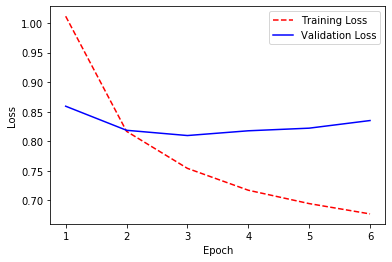

In [16]:


import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



In [18]:
y_pred=model.predict_classes(X_test)

In [23]:
df = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
df.head(25)

Exception: Data must be 1-dimensional

In [31]:
import pickle

pickle_out = open(r"C:\Users\Gaming\Movie review data\sentences.pickle","wb")
pickle.dump(train_sentences, pickle_out)
pickle_out.close()

pickle_out = open(r"C:\Users\Gaming\Movie review data\Target.pickle","wb")
pickle.dump(y_target, pickle_out)
pickle_out.close()

In [28]:
y_target

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)